# Homework 3
*This notebook includes both coding and written questions. Please hand in this notebook file with all the outputs and your answers to the written questions.*

This assignment covers K-Means and mean shift methods for clustering and image segmentation.

In [19]:
# Setup
from __future__ import print_function
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from skimage import io
from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Introduction
In this assignment, you will use clustering algorithms to segment images. You will then use these segmentations to identify foreground and background objects.

Your assignment will involve the following subtasks:
- **K-means clustering**: Understand the principle of kmeans and implement K-Means clustering.
- **Mean shift clustering**: Understand the principle of mean-shift and implement Mean Shift clustering.
- **Results comparison**: Try the above two methods on the image segmentation task and compare the performance.

## 1 K-means Clustering Algorithms (total 30 points)
K-Means clustering is an unsupervised learning algorithm. There is no labeled data for this clustering, unlike in supervised learning. K-Means performs the division of objects into clusters that share similarities and are dissimilar to the objects belonging to another cluster. The K-Means clustering algorithm is an iterative process where you are trying to minimize the distance of the data point from the average data point in the cluster.

<img src=./images/kmean_sample.gif width=100% />

reference: https://www.linkedin.com/pulse/k-means-clustering-its-real-use-case-surayya-shaikh

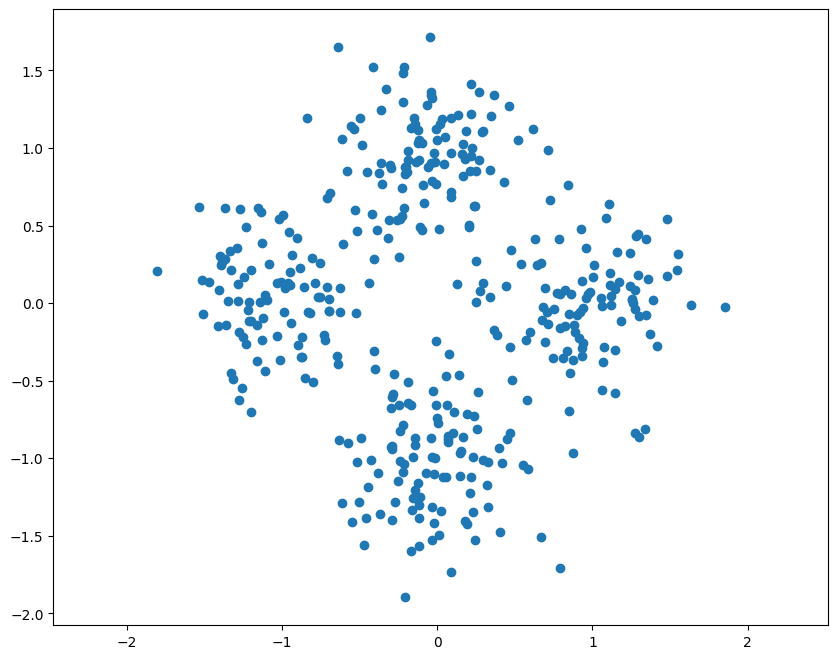

In [20]:
# Generate random data points for clustering

# Set seed for consistency
np.random.seed(0)

# Cluster 1
mean1 = [-1, 0]
cov1 = [[0.1, 0], [0, 0.1]]
X1 = np.random.multivariate_normal(mean1, cov1, 100)

# Cluster 2
mean2 = [0, 1]
cov2 = [[0.1, 0], [0, 0.1]]
X2 = np.random.multivariate_normal(mean2, cov2, 100)

# Cluster 3
mean3 = [1, 0]
cov3 = [[0.1, 0], [0, 0.1]]
X3 = np.random.multivariate_normal(mean3, cov3, 100)

# Cluster 4
mean4 = [0, -1]
cov4 = [[0.1, 0], [0, 0.1]]
X4 = np.random.multivariate_normal(mean4, cov4, 100)

# Merge two sets of data points
X = np.concatenate((X1, X2, X3, X4))

# Plot data points
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal')
plt.show()

### 1.1 K-Means Clustering (10 points)
As discussed in class, K-Means is one of the most popular clustering algorithms. We have provided skeleton code for K-Means clustering in the file `segmentation.py`. Your first task is to finish implementing **`kmeans`** in `segmentation.py`. This version uses nested for loops to assign points to the closest centroid and compute a new mean for each cluster.

We can manually implement the kmeans algorithm by looping through, but we can use numpy functions and broadcasting to make K-Means faster. This should run at least 10 times faster than the implementation of only `for looping`.

If you are interested, you can compare the time overhead of using broadcasting and for loops, and record them. (Optional, no score)

(400, 2)
kmeans running time: 0.002316 seconds.


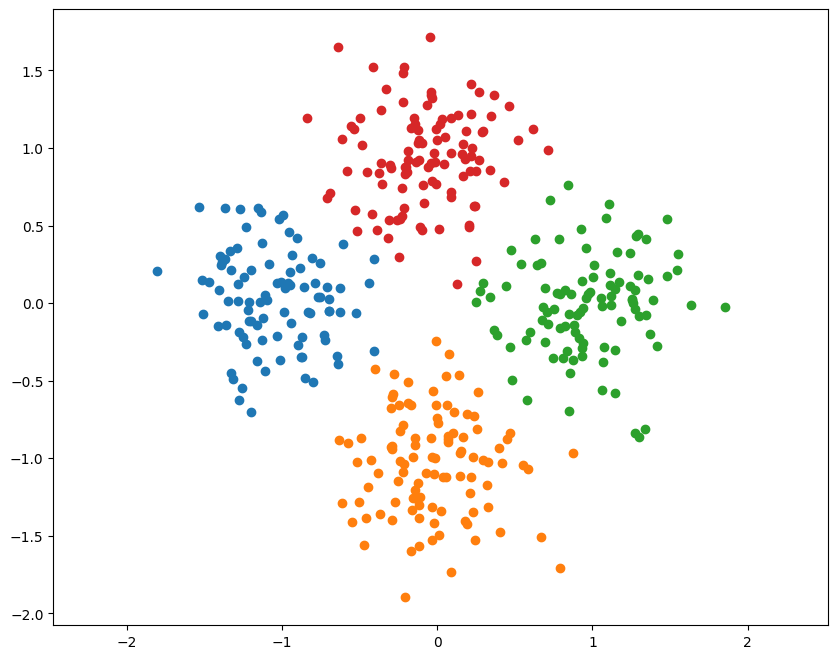

In [21]:
from segmentation import kmeans

np.random.seed(0)
start = time()
assignments = kmeans(X, 4)
end = time()

kmeans_runtime = end - start

print("kmeans running time: %f seconds." % kmeans_runtime)

for i in range(4):
    cluster_i = X[assignments==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])

plt.axis('equal')
plt.show()

### 1.2 K-Means Convergence (10 points)
Implementations of the K-Means algorithm will often have the parameter `num_iters` to define the maximum number of iterations the algorithm should run for. Consider that we opt to not include this upper bound on the number of iterations, and that we define the termination criterion of the algorithm to be when the cost $L$ stops changing.

Recall that $L$ is defined as the sum of squared distance between all points $x$ and their nearest cluster center $c$:

$$L = \sum_{i \in clusters}\sum_{x \in cluster_i} (x - c_i)^2$$

Show that for any set of points **$D$** and any number of clusters $k$, the K-Means algorithm will terminate in a finite number of iterations.

**Your answer here:**

K-Means 算法的目标是最小化以下目标函数 $L$：
$$L = \sum_{i \in clusters}\sum_{x \in cluster_i} (x - c_i)^2$$
其中：
- $cluster_i$ 表示第 $i$ 个簇中的点集合；
- $c_i$ 是第 $i$ 个簇的中心（即簇内所有点的均值）；
- $k$ 是簇的数量。

##### **1. 目标函数 $L$ 的性质**
1. **非负性**  
   $$
   \|x - c_i\|^2 \geq 0 \implies L \geq 0.
   $$

2. **单调递减性**  
   在每次迭代中，K-Means 算法执行两个步骤：
   - **分配步骤（Assignment Step）**：将每个点分配到最近的簇中心，从而最小化当前簇分配下的 $L$。
   - **更新步骤（Update Step）**：重新计算每个簇的中心 $c_i$，使得该簇内的平方误差最小化。

   这两个步骤保证了 $L$ 在每次迭代中都不会增加：
   $$
   L_{t+1} \leq L_t,
   $$
   其中 $L_t$ 表示第 $t$ 次迭代时的目标函数值。

3. **离散性**  
   数据点 $D$ 是有限的，簇的数量 $k$ 是固定的，因此可能的簇划分方式是有限的。每种簇划分对应一个特定的目标函数值 $L$，导致 $L$ 的所有可能取值也是有限的。

---

##### **2. 收敛性分析**
根据上述性质，我们可以得出以下结论：

1. **有限状态空间**  
   数据集 $D$ 中的点是有限的，且簇的数量 $k$ 是固定的。因此，所有可能的簇划分方式是有限的：
   $$
   \text{Number of possible clusterings} < \infty.
   $$

2. **严格递减或稳定**  
   每次迭代中，$L$ 要么严格减小，要么保持不变。如果 $L$ 保持不变，则说明算法已经收敛，因为此时簇划分和簇中心都不再发生变化。

3. **有限步终止**  
   由于 $L$ 是非负的、单调递减的，并且其可能的取值是有限的，因此经过有限次迭代后，$L$ 必定会达到一个稳定的值（即不再变化）。此时，算法终止。

---

#### **结论**
综上所述，无论数据集 $D$ 和簇数量 $k$ 如何，K-Means 算法都会在有限次迭代后终止。

### 1.3 Image Segmentation based on K-means (10 points)
When we use kmeans for image segmentation, the color information of pixels is used for clustering, so each of our pixels can be regarded as a vector composed of R, G, and B, and RGB is our color feature.

The specific process is similar to our example above, but the calculation object is changed from a scalar to a 3-dimensional vector.

Please implement the `kmean_color` function in `segmentation.py` and call it to complete the segmentation of color images. (very similar to `kmeans function`)

(13056, 3)
kmeans_clustering running time: 0.173621 seconds.


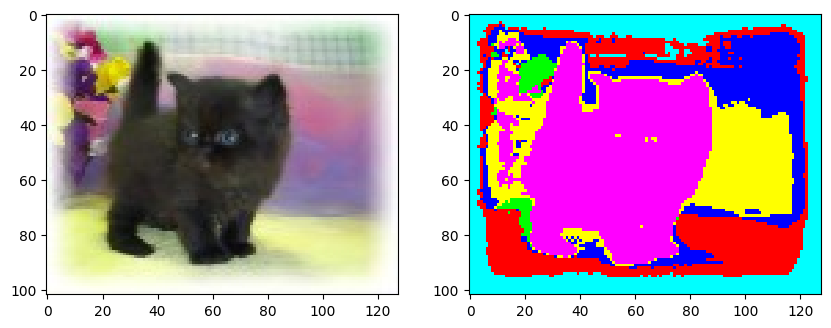

In [45]:
from segmentation import kmeans_color
img = io.imread('example.jpg')
#img = img[...,[2,1,0]]
plt.figure()
plt.subplot(1,2,1)
plt.imshow(img)
k=6
cluster_color=[[255,0,0],[0,255,0],[0,0,255],[255,255,0],[255,0,255],[0,255,255]]
start = time()
assignments = kmeans_color(img, k)
end = time()

print("kmeans_clustering running time: %f seconds." % (end - start))
res_img=np.array(img)
for i in range(k):
    res_img[assignments==i]=cluster_color[i]
plt.subplot(1,2,2)
plt.imshow(res_img)
plt.show()

We can try different values of k and number of iterations and observe the difference in the results.

## 2 Mean Shift Clustering (total 50 points)
### 2.1 Mean Shift
Mean shift is a procedure for locating the maxima—the modes—of a density function given discrete data sampled from that function.  This is an iterative method, and we start with an initial estimate $x$, Let a kernel function $K(x_{i}-x)$ be given. This function determines the weight of nearby points for re-estimation of the mean. Typically a Gaussian kernel on the distance to the current estimate is used, $K(x_{i}-x)=e^{-c||x_{i}-x||^{2}}$. The weighted mean of the density in the window determined by $K$ is:

$$ m(x)=\frac{\sum_{x_{i} \in N(x)} K(x_{i}-x) x_{i}}{\sum_{x_{i}\in N(x)}K(x_{i}-x)} $$

where $N(x)$ is the neighborhood of $x$, a set of points for which $K(x_{i}-x)\neq 0$. The difference $m(x)-x$ between mean and specific point is called mean shift in Fukunaga and Hostetler. The mean-shift algorithm now sets $x\leftarrow m(x)$, and repeats the extimation until $m(x)$ converges.

mean shift example: specific one sample:

It will "move" towards the direction with the highest density within a fixed range. "Move' in the segmentation is just an abstract way of saying that the point representing the pixel is more likely to belong to the category of the pixel with the highest density.

<img src=./images/mean-shift-vector.gif width=100% />

mean shift example: all samples:
<img src=./images/mean-shift.gif width=100% />


Let's use the meanshift function in sklearn to try it out on the previous example:

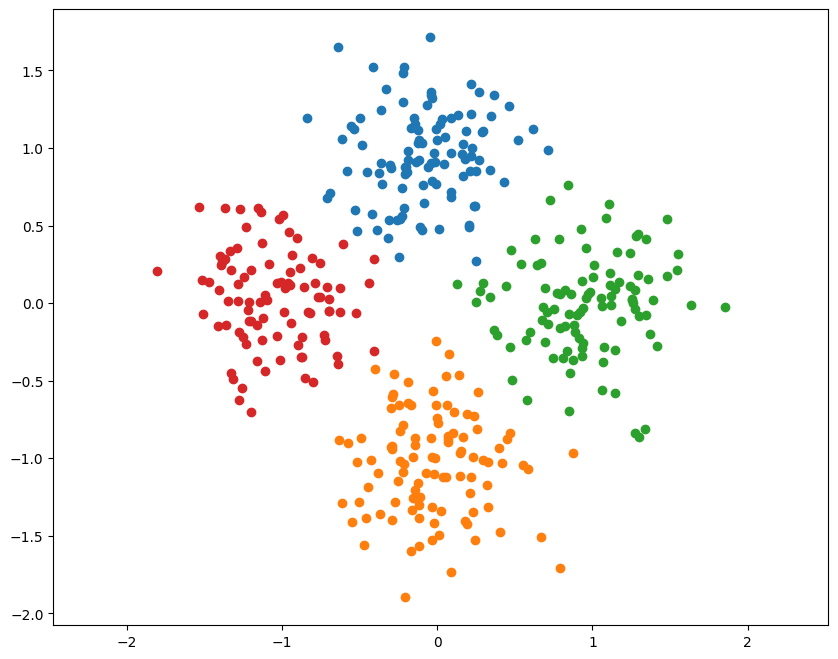

In [46]:
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=1000)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
k=len(list(set(labels)))
for i in range(k):
    cluster_i = X[labels==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])

plt.axis('equal')
plt.show()

### 2.2 Implementation of Mean Shift (30 points)
We try to implement the mean shift algorithm manually. the process is:

- **(1)**: Calculate the mean vector for each sample;
- **(2)**: Offset the mean vector from which samples are computed;
- **(3)**: Repeat the previous two processes, and set the iteration stop condition, such as the mean shift is less than a certain threshold;
- **(4)**: Samples that converge to the same point are considered to be members of the same cluster class

In [ ]:
from segmentation import segmIm
img = io.imread('./example.jpg')

# 运行 Mean Shift 算法，超参可以自己调整
res_img=segmIm(img, 20)


Note: Since the mean shift algorithm usually calculates the mean vector for all points in the whole image, the convergence speed is slow. If the image is large, we generally perform compression processing. (Our example is already compressed)


In [ ]:
plt.close()
plt.figure()
plt.subplot(1,2,1)
plt.imshow(img)

plt.subplot(1,2,2)
plt.imshow(res_img)
#输出的是灰度图，并不是前景的mask
plt.show()

### 2.3 Calculate the performance (10 points)
Match the prediction result with gt pixel by pixel, finish the `compute_accuracy` function in the `segmentation.py`

In [ ]:
from segmentation import compute_accuracy
from skimage import color
#Set the foreground to 0, the background to 0
pred_mask=res_img
gt=np.array(io.imread('./gt.png'))[:,:,:3]# Omit the fourth channel
gt=color.rgb2gray(gt)
gt_mask=(gt <= 0.5).astype(int)

#筛选前景，超参可调整
pred_mask=(pred_mask >= 0.5).astype(int)

acc=compute_accuracy(pred_mask, gt_mask)
print(acc)

### 2.4 Question (10 points)
In the above attempts, it can be found that the clustering process of shift mean is slow when facing large images. Please give several methods to speed up the algorithm. (including pre-processing or post-processing)

**Your answer here:**
1. 压缩图像
2. 并行计算
3. 选用计算效率高的核函数

## 3 Comparison of kmeans and mean shift (20 points)
We want to specifically compare the performance of kmeans and mean shift methods on foreground segmentation.

For foreground segmentation, we only need to segment certain specific objects, such as cats, dogs, beds, and so on. The objects that need to be segmented on the small amount of data we use for comparison are all cats, but the number of cats is variable.

For mean shift, two clusters are generated most of the time in our task (There are many categories, choose the appropriate category as the prospect according to your needs), and for kmeans, we only need to set k=2.

Please use the previously implemented code in the following block to traverse the entire dataset and output the accuracy results of using the kmeans and mean shift methods on each image.

It should be emphasized that because the mean shift algorithm is slow, you can use the image compression method to compress the image first, but the aspect ratio of the image cannot be changed (our recommendation is 128*102)

How to determine which of the outcomes is the prediction we want?
   It can be calculated with that the max area of overlapping of the groundtruth or to observe manually.

Note: There is rgb noise in the ground truth image, it is not a complete black and white image, pay attention to the threshold of binarization.

Note: allow flexible adjustment of hyperparameters for different images.

And visualize each image: original; kmeans result; mean shift result.

In [ ]:
import os
image_files=os.listdir('./data/imgs')
images=[]
gts=[]
masks=[]
for i in image_files:
    images.append(os.path.join('./data/imgs',i))
    gts.append(os.path.join('./data/gt',i))
for i in range(len(images)):
    ### YOUR CODE HERE # 10 points
    pass
    #kmeans
    km_mask=None
    #mean shift
    ms_mask=None
    #gt
    gt_mask=None
    ### END YOUR CODE
    #kmeans
    masks.append([km_mask,ms_mask,gt_mask])
    #output three masks

visualize:

In [ ]:
#visualize
plt.figure()

for i in range(len(masks)):
    ### YOUR CODE HERE # 10 points
    km_acc=None
    ms_acc=None
    pass
    ### END YOUR CODE
    print(i, " kmeans: ", km_acc, ' , mean_shift: ', ms_acc)

for i in range(len(masks)):
    plt.subplot(1, 3, 1)
    plt.imshow(masks[i][2])
    plt.title('gt')
    plt.subplot(1, 3, 2)
    plt.imshow(masks[i][0])
    plt.title('kmeans')
    plt.subplot(1, 3, 3)
    plt.imshow(masks[i][1])
    plt.title('mean shift')
    plt.show()


visualize the results, for example:
<img src=./images/visual.png width=100% />